## Find EMIT agricultural images and download

### Setup notebook

Import packages

In [1]:
# Import modules and env vars
import os, time
import shutil
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import matplotlib.pyplot as plt
from rasterio.plot import show

dest = '/home/jovyan/HYR_SENSE/'

print("Success!")

Success!


### Setup paths

In [2]:
"""
Copy the data-store to 'local' directory
This enables quick access to data files
"""

#import shutil

data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/'
dest = '/home/jovyan/HYR-SENSE/data/'

shutil.copytree(data_store_path, dest)

FileExistsError: [Errno 17] File exists: '/home/jovyan/HYR-SENSE/data/'

### Setup the Regions of Interest for image search

In [15]:
# Load the ag data (ROI, irrigation, crop type)

# Region of interest
roi = os.path.join(dest,'data/co_agriculture.geojson')
roi = gpd.read_file(roi)

# # Irrigated lands
# irrig = os.path.join(dest,'data/Div1_irrigated_co_agriculture.gpkg')
# irrig = gpd.read_file(irrig)

# NASS CDL (ca. 2023)
cdl = os.path.join(dest,'data/CDL_2023_CO.tif')
cdl = rxr.open_rasterio(cdl, mask=True, cache=False).squeeze()
cdl = cdl.rio.clip(roi.geometry) # clip to the roi

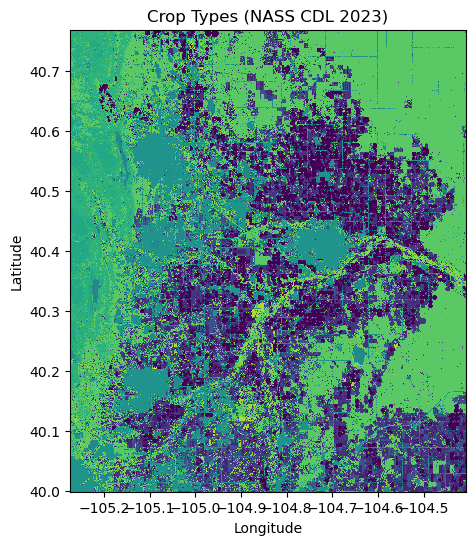

In [25]:
# Plot the ROI data
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
roi.plot(ax=ax, color='white', edgecolor='black')
cdl.plot(ax=ax, add_colorbar=False, cmap='viridis')  # Customize the colormap as neededplt.title('ROI for Agriculture Lands in South Platte Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crop Types (NASS CDL 2023)')
plt.show()

## Search for EMIT Scenes

In [27]:
import earthaccess 
earthaccess.login(persist=True)

Enter your Earthdata Login username:  maco4303
Enter your Earthdata password:  ········


Persisting credentials to .netrc


In [29]:
# Query the collections
Query = earthaccess.collection_query().keyword('emit').provider('LPCLOUD')
print(f'Collections found: {Query.hits()}')
# Return EMIT specific products
collections = Query.fields(['ShortName']).get(4)
# Retrieve Collection Short-names
[product['short-name'] for product in [collection.summary() for collection in collections]]

Collections found: 7


['EMITL2ARFL', 'EMITL2BCH4ENH', 'EMITL2BCH4PLM', 'EMITL2BMIN']

In [39]:
# ~ Extract a list coordinate pairs for ROI ~
# First, reproject to WGS84 for coordinates are in degrees
roi = roi.to_crs(epsg=4326)
# Extract the bounds
coord_list = []
for iter, row in roi.iterrows():
    bounds = row['geometry'].bounds
    coord_list.append(bounds)
print(coord_list)

[(-105.27351998251136, 39.99923861162608, -104.40858020820149, 40.76956093643457)]


In [43]:
# Search for EMIT data
search_results = earthaccess.search_data(
    short_name='EMITL2ARFL',
    bounding_box=bounds,
    temporal=('2023-05-01','2023-09-28'),
    count=100
)
# Extract the json as data frame
search_df = pd.json_normalize(search_results)
search_df.head()

Granules found: 14


,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,...,umm.PGEVersionClass.PGEVersion,umm.RelatedUrls,umm.CloudCover,umm.DataGranule.DayNightFlag,umm.DataGranule.ArchiveAndDistributionInformation,umm.DataGranule.ProductionDateTime,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version
0,3576.482238,granule,G2702497598-LPCLOUD,2,EMIT_L2A_RFL_001_20230529T211859_2314914_020,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-27T02:35:31.204Z,2023-05-29T21:18:59Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,99,Day,[{'Name': 'EMIT_L2A_RFL_001_20230529T211859_23...,2023-06-22T16:40:36Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5
1,3579.189075,granule,G2701558381-LPCLOUD,2,EMIT_L2A_RFL_001_20230529T211911_2314914_021,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-27T21:12:25.885Z,2023-05-29T21:19:11Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,85,Day,[{'Name': 'EMIT_L2A_RFL_001_20230529T211911_23...,2023-06-22T16:40:48Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5
2,3573.766212,granule,G2701558257-LPCLOUD,2,EMIT_L2A_RFL_001_20230529T211923_2314914_022,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-26T20:06:45.998Z,2023-05-29T21:19:23Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,98,Day,[{'Name': 'EMIT_L2A_RFL_001_20230529T211923_23...,2023-06-22T16:41:04Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5
3,3576.696239,granule,G2719513326-LPCLOUD,1,EMIT_L2A_RFL_001_20230602T194051_2315313_018,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-24T22:47:36.731Z,2023-06-02T19:40:51Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,97,Day,[{'Name': 'EMIT_L2A_RFL_001_20230602T194051_23...,2023-06-18T00:34:58Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5
4,3577.205499,granule,G2715759107-LPCLOUD,2,EMIT_L2A_RFL_001_20230602T194102_2315313_019,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2023-06-24T22:47:38.272Z,2023-06-02T19:41:02Z,...,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,95,Day,[{'Name': 'EMIT_L2A_RFL_001_20230602T194102_23...,2023-06-18T00:35:08Z,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5


In [45]:
print(search_df.columns)

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime', 'umm.GranuleUR',
       'umm.AdditionalAttributes',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEName',
       'umm.PGEVersionClass.PGEVersion', 'umm.RelatedUrls', 'umm.CloudCover',
       'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.ArchiveAndDistributionInformation',
       'umm.DataGranule.ProductionDateTime', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version'],
      dtype='object')


In [50]:
# Find cloud-free granules
print(search_df['umm.CloudCover'].describe)
# Get the minimum cloud cover
min_index = search_df['umm.CloudCover'].idxmin() # index of the granule with min cloud cover
low_clouds = search_df.loc[min_index]
print(low_clouds)

<bound method NDFrame.describe of 0     99
1     85
2     98
3     97
4     95
5     77
6     22
7     29
8     43
9     23
10     8
11    21
12    34
13    39
Name: umm.CloudCover, dtype: int64>
size                                                                                                   3581.19547
meta.concept-type                                                                                         granule
meta.concept-id                                                                               G2736967625-LPCLOUD
meta.revision-id                                                                                                1
meta.native-id                                                       EMIT_L2A_RFL_001_20230625T170814_2317611_005
meta.collection-concept-id                                                                    C2408750690-LPCLOUD
meta.provider-id                                                                                          LPCLOUD
meta.f

In [56]:
# Download the scenes, store in scratch folder

# Retrieve the download URL
granule_id = [low_clouds['umm.GranuleUR'] + "/" + low_clouds['umm.GranuleUR'] + ".nc"]
print(granule_id)

# Get Https Session using Earthdata Login Info
fs = earthaccess.get_fsspec_https_session()

# Base download URL
base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001'

# Define local storage location on CyVerse - default is HYR-SENSE/data/emit
loc_file_path = os.path.join('/home/jovyan/HYR-SENSE/data/emit/')
if not os.path.exists(loc_file_path):
    os.mkdir(loc_file_path)

# Download the data granules
t0 = time.time()

print("Granule ID: " + granule_id[0].split('/')[1])
granule_asset_id = granule_id[0].split('/')[1]
out_path = loc_file_path + f'{granule_asset_id}'

# Download the Granule Asset if it doesn't exist
url = os.path.join(base_url,granule_id[0])
if not os.path.isfile(out_path):
    fs.download(url, out_path)

print('Total time:', time.time() - t0)

['EMIT_L2A_RFL_001_20230625T170814_2317611_005/EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc']
Granule ID: EMIT_L2A_RFL_001_20230625T170814_2317611_005.nc
Total time: 58.23762583732605


In [ ]:
# (Optional) Copy data to CyVerse data store for download
dest = '/data-store/iplant/home/maco4303'
shutil.copytree(folder_with_data, dest)